In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from scipy import integrate
from fourier_1d import *
from scipy.stats import multivariate_normal

In [2]:
x_data = np.load('data/spde_ib_x.npy')
y_data = np.load('data/spde_ib_y.npy')[:,50]

In [3]:
x_grid = np.linspace(0, 1, x_data.shape[-1])

ntrain = 900
ntest = 100

batch_size = 50
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64

x_train = x_data[:ntrain]
y_train = y_data[:ntrain]
x_test = x_data[-ntest:]
y_test = y_data[-ntest:]
x_grid = x_grid[:]

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

x_train = torch.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

model = FNO1d(modes, width, x_grid[0], x_grid[-1]).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='\n', flush=True)

print('Total training time:',default_timer()-start,'s')

Total parameters: 549569
epoch 1/500 L2 = 1.846900, MSE = 0.003473, using 2.535221s
epoch 2/500 L2 = 1.191306, MSE = 0.002443, using 0.120272s
epoch 3/500 L2 = 0.980809, MSE = 0.002236, using 0.119173s
epoch 4/500 L2 = 0.972433, MSE = 0.001898, using 0.119788s
epoch 5/500 L2 = 0.954851, MSE = 0.001827, using 0.119140s
epoch 6/500 L2 = 0.935937, MSE = 0.001669, using 0.119241s
epoch 7/500 L2 = 0.923902, MSE = 0.001641, using 0.119742s
epoch 8/500 L2 = 0.835181, MSE = 0.001429, using 0.119304s
epoch 9/500 L2 = 0.820180, MSE = 0.001232, using 0.121685s
epoch 10/500 L2 = 0.672758, MSE = 0.000697, using 0.120422s
epoch 11/500 L2 = 0.669480, MSE = 0.000339, using 0.118860s
epoch 12/500 L2 = 0.503938, MSE = 0.000207, using 0.119603s
epoch 13/500 L2 = 0.438926, MSE = 0.000107, using 0.120596s
epoch 14/500 L2 = 0.346221, MSE = 0.000092, using 0.120590s
epoch 15/500 L2 = 0.417245, MSE = 0.000149, using 0.124246s
epoch 16/500 L2 = 0.300025, MSE = 0.000100, using 0.119832s
epoch 17/500 L2 = 0.3742

epoch 137/500 L2 = 0.022529, MSE = 0.000001, using 0.118857s
epoch 138/500 L2 = 0.018299, MSE = 0.000000, using 0.118936s
epoch 139/500 L2 = 0.034478, MSE = 0.000001, using 0.119099s
epoch 140/500 L2 = 0.046583, MSE = 0.000001, using 0.119346s
epoch 141/500 L2 = 0.049418, MSE = 0.000002, using 0.120322s
epoch 142/500 L2 = 0.028326, MSE = 0.000001, using 0.119025s
epoch 143/500 L2 = 0.018661, MSE = 0.000000, using 0.119107s
epoch 144/500 L2 = 0.022312, MSE = 0.000000, using 0.118867s
epoch 145/500 L2 = 0.034085, MSE = 0.000001, using 0.118294s
epoch 146/500 L2 = 0.025341, MSE = 0.000001, using 0.118556s
epoch 147/500 L2 = 0.029056, MSE = 0.000001, using 0.119948s
epoch 148/500 L2 = 0.022264, MSE = 0.000001, using 0.118748s
epoch 149/500 L2 = 0.051193, MSE = 0.000002, using 0.118393s
epoch 150/500 L2 = 0.036023, MSE = 0.000001, using 0.118452s
epoch 151/500 L2 = 0.017574, MSE = 0.000000, using 0.119971s
epoch 152/500 L2 = 0.012835, MSE = 0.000000, using 0.119039s
epoch 153/500 L2 = 0.011

epoch 272/500 L2 = 0.007644, MSE = 0.000000, using 0.118693s
epoch 273/500 L2 = 0.007759, MSE = 0.000000, using 0.119242s
epoch 274/500 L2 = 0.007889, MSE = 0.000000, using 0.118652s
epoch 275/500 L2 = 0.007553, MSE = 0.000000, using 0.119059s
epoch 276/500 L2 = 0.007494, MSE = 0.000000, using 0.118996s
epoch 277/500 L2 = 0.007519, MSE = 0.000000, using 0.118648s
epoch 278/500 L2 = 0.008148, MSE = 0.000000, using 0.119051s
epoch 279/500 L2 = 0.009339, MSE = 0.000000, using 0.118185s
epoch 280/500 L2 = 0.008110, MSE = 0.000000, using 0.118452s
epoch 281/500 L2 = 0.007931, MSE = 0.000000, using 0.118409s
epoch 282/500 L2 = 0.007738, MSE = 0.000000, using 0.118925s
epoch 283/500 L2 = 0.007297, MSE = 0.000000, using 0.118299s
epoch 284/500 L2 = 0.007104, MSE = 0.000000, using 0.119573s
epoch 285/500 L2 = 0.008327, MSE = 0.000000, using 0.119088s
epoch 286/500 L2 = 0.007694, MSE = 0.000000, using 0.118800s
epoch 287/500 L2 = 0.007446, MSE = 0.000000, using 0.119613s
epoch 288/500 L2 = 0.010

epoch 407/500 L2 = 0.006153, MSE = 0.000000, using 0.119261s
epoch 408/500 L2 = 0.006186, MSE = 0.000000, using 0.119615s
epoch 409/500 L2 = 0.006215, MSE = 0.000000, using 0.119434s
epoch 410/500 L2 = 0.006316, MSE = 0.000000, using 0.118747s
epoch 411/500 L2 = 0.006285, MSE = 0.000000, using 0.118694s
epoch 412/500 L2 = 0.006256, MSE = 0.000000, using 0.118841s
epoch 413/500 L2 = 0.006272, MSE = 0.000000, using 0.118591s
epoch 414/500 L2 = 0.006389, MSE = 0.000000, using 0.119090s
epoch 415/500 L2 = 0.006267, MSE = 0.000000, using 0.119356s
epoch 416/500 L2 = 0.006184, MSE = 0.000000, using 0.118926s
epoch 417/500 L2 = 0.006187, MSE = 0.000000, using 0.118673s
epoch 418/500 L2 = 0.006442, MSE = 0.000000, using 0.118694s
epoch 419/500 L2 = 0.006207, MSE = 0.000000, using 0.118887s
epoch 420/500 L2 = 0.006422, MSE = 0.000000, using 0.118611s
epoch 421/500 L2 = 0.006285, MSE = 0.000000, using 0.118973s
epoch 422/500 L2 = 0.006373, MSE = 0.000000, using 0.119081s
epoch 423/500 L2 = 0.006

In [4]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
        
    test_mse /= len(test_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)

test error: L2 = 0.00843488639802672 , MSE = 2.7389291193946618e-08


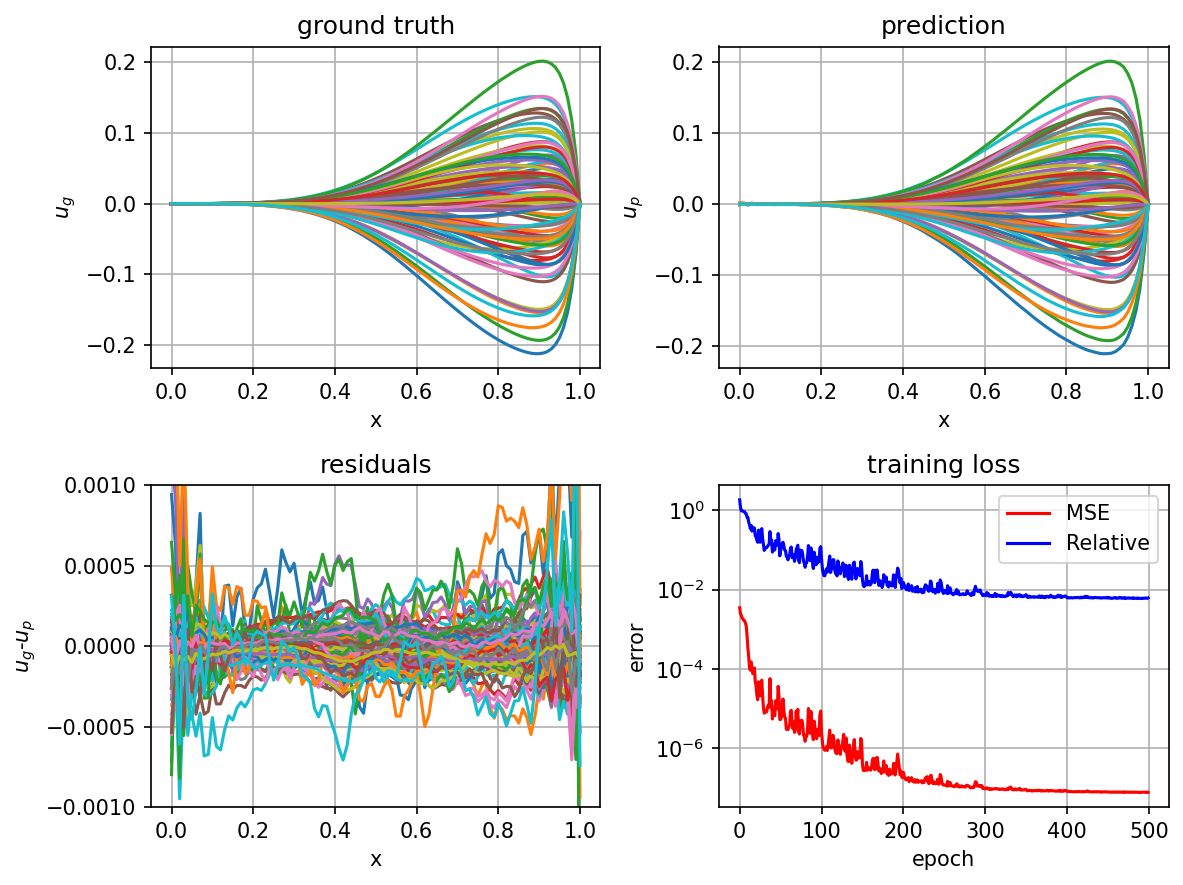

In [5]:
residual = pred-y_test
fig = plt.figure(figsize=(8,6),dpi=150)

plt.subplot(2,2,1)
plt.title("ground truth")
for i in range(ntest):
    plt.plot(x_grid,y_test[i])
plt.xlabel("x")
plt.ylabel("$u_g$")
plt.grid()

plt.subplot(2,2,2)
plt.title("prediction")
for i in range(ntest):
    plt.plot(x_grid,pred[i])
plt.xlabel("x")
plt.ylabel("$u_p$")
plt.grid()

plt.subplot(2,2,3)
plt.title("residuals")
plt.ylim([-0.001,0.001])
for i in range(ntest):
    plt.plot(x_grid,residual[i])
plt.xlabel("x")
plt.ylabel("$u_g$-$u_p$")
plt.grid()
    
plt.subplot(2,2,4)
plt.title("training loss")
plt.plot(MSE,c='r',label='MSE')
plt.plot(L2,c='b',label='Relative')
plt.legend()
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("error")
plt.grid()

plt.tight_layout()
plt.show()

In [6]:
v = torch.zeros(ntest)
m = torch.zeros(ntest)
for i in range(ntest):
    v[i] = torch.var(residual[i],unbiased=False)
    m[i] = torch.mean(residual[i])
print(torch.mean(m),torch.mean(v))

tensor(-5.0137e-06) tensor(2.0031e-08)


In [7]:
mse = MSE.numpy().reshape(1,MSE.shape[0])
l2 = L2.numpy().reshape(1,L2.shape[0])
loss = np.concatenate((mse,l2))
np.save("data/fno_loss_ib.npy",loss)
torch.save(model,"model/fno_ib")